# Voice Analysis Notebook
This notebook performs various analyses on voice recordings including:
- Spectrogram analysis (narrow and wide band)
- Pitch estimation
- Formant analysis
- Cepstral analysis

In [19]:
# Import necessary libraries
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pydub import AudioSegment
import warnings
from scipy.signal import butter, lfilter, filtfilt
warnings.filterwarnings('ignore')

In [20]:
def preprocess_audio(signal, sampling_rate):
    """
    Improved audio preprocessing function with gentler filtering.
    """
    # Convert to mono if stereo
    if len(signal.shape) > 1:
        signal = signal.mean(axis=1)
    
    # Convert to float32 and normalize
    signal = signal.astype(np.float32)
    signal = signal / np.max(np.abs(signal))
    
    # Remove DC offset
    signal = signal - np.mean(signal)
    
    # Apply gentle pre-emphasis
    pre_emphasis = 0.95
    signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    
    # Apply bandpass filter for speech range (50Hz-10000Hz)
    nyquist = sampling_rate / 2
    low = 50 / nyquist
    high = 10000 / nyquist
    b, a = butter(2, [low, high], btype='band')
    signal = filtfilt(b, a, signal)
    
    return signal

def convert_and_load_audio(input_file, output_file='converted_audio.wav'):
    """
    Convert m4a to wav and load the audio file with improved error handling.
    """
    try:
        # Convert m4a to wav
        print(f"Converting {input_file} to {output_file}...")
        audio = AudioSegment.from_file(input_file, format='m4a')
        
        # Standardize audio properties
        audio = audio.set_channels(1)
        audio = audio.set_frame_rate(44100)
        audio = audio.set_sample_width(2)
        
        audio.export(output_file, format='wav')
        
        # Load the converted file
        print("Loading audio file...")
        sampling_rate, signal = wav.read(output_file)
        
        # Apply preprocessing
        signal = preprocess_audio(signal, sampling_rate)
        
        print(f"Audio loaded successfully. Sampling rate: {sampling_rate} Hz")
        return sampling_rate, signal
    
    except Exception as e:
        print(f"Error loading audio: {e}")
        return None, None

In [21]:
def plot_spectrograms(signal, sampling_rate, title_prefix=""):
    """
    Plot both narrow-band and wide-band spectrograms side by side.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Narrow-band spectrogram
    ax1.specgram(signal, NFFT=2048, Fs=sampling_rate, 
                noverlap=1024, cmap='viridis')
    ax1.set_title(f'{title_prefix} Narrow-band Spectrogram')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Frequency (Hz)')
    
    # Wide-band spectrogram
    ax2.specgram(signal, NFFT=512, Fs=sampling_rate, 
                noverlap=384, cmap='viridis')
    ax2.set_title(f'{title_prefix} Wide-band Spectrogram')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Frequency (Hz)')
    
    plt.tight_layout()
    plt.show()

In [ ]:
def estimate_pitch(signal, sampling_rate):
    """
    Improved pitch estimation specifically tuned for male voices.
    Male fundamental frequency (F0) typically ranges from 85-180 Hz,
    so we'll adjust our parameters accordingly.
    """
    # Parameters specifically tuned for male voices
    frame_length = 2048  # Longer frame for better low-frequency resolution
    hop_length = 512
    fmin = 60  # Lower minimum to catch deep male voices
    fmax = 200  # Upper limit for male voices
    
    # Apply center clipping to reduce formant interference
    threshold = 0.3 * np.max(np.abs(signal))
    center_clipped = np.where(np.abs(signal) < threshold, 0, signal)
    
    # Define AMD function
    def get_pitch_amd(frame):
        amd = np.zeros(len(frame))
        for lag in range(1, len(frame)):
            amd[lag] = np.sum(np.abs(frame[:-lag] - frame[lag:]))
        
        # Find the minimum in AMD
        min_lag = np.argmin(amd[fmin:fmax]) + fmin
        return sampling_rate / min_lag
    
    # Process in frames
    frame_samples = librosa.util.frame(center_clipped, 
                                       frame_length=frame_length, 
                                       hop_length=hop_length)
    
    amd_pitches = []
    for frame in frame_samples.T:
        pitch = get_pitch_amd(frame)
        if fmin <= pitch <= fmax:
            amd_pitches.append(pitch)
    
    if len(amd_pitches) > 0:
        # Apply median filtering to remove outliers
        amd_pitches = np.array(amd_pitches)
        amd_pitches = np.median(
            librosa.util.frame(amd_pitches, 
                               frame_length=5, 
                               hop_length=1), 
            axis=0
        )
        
        # Calculate statistics
        mean_pitch = np.mean(amd_pitches)
        median_pitch = np.median(amd_pitches)
        std_pitch = np.std(amd_pitches)
        
        # Plot pitch contour with confidence
        plt.figure(figsize=(12, 6))
        
        # Plot AMD results
        times = librosa.times_like(amd_pitches, sr=sampling_rate, hop_length=hop_length)
        plt.plot(times, amd_pitches, 'b-', label='Pitch contour', alpha=0.6)
        plt.axhline(y=mean_pitch, color='r', linestyle='--', label='Mean pitch')
        plt.fill_between(times, 
                         amd_pitches - std_pitch, 
                         amd_pitches + std_pitch, 
                         alpha=0.2, 
                         color='blue')
        plt.title('Pitch Contour (AMD method)')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed statistics
        print("\nDetailed Pitch Analysis:")
        print(f"Mean pitch: {mean_pitch:.1f} Hz")
        print(f"Median pitch: {median_pitch:.1f} Hz")
        print(f"Pitch std dev: {std_pitch:.1f} Hz")
        
        return {
            'mean': mean_pitch,
            'median': median_pitch,
            'std': std_pitch
        }
    return None

In [23]:
def estimate_formants(signal, sampling_rate):
    """
    Improved formant estimation using enhanced LPC analysis.
    """
    # Frame the signal
    frame_length = int(0.025 * sampling_rate)  # 25ms frames
    hop_length = int(0.01 * sampling_rate)     # 10ms hop
    
    # Calculate the number of frames
    num_frames = 1 + (len(signal) - frame_length) // hop_length
    
    formants_frames = []
    
    for i in range(num_frames):
        start = i * hop_length
        end = start + frame_length
        frame = signal[start:end]
        
        # Apply Hamming window
        frame = frame * np.hamming(len(frame))
        
        # LPC analysis
        order = int(2 + sampling_rate / 1000)  # Rule of thumb for LPC order
        lpc_coeffs = librosa.lpc(frame, order=order)
        
        # Find roots of the LPC polynomial
        roots = np.roots(lpc_coeffs)
        
        # Keep only roots with positive imaginary parts
        roots = roots[np.imag(roots) >= 0]
        
        # Convert to frequencies
        angles = np.angle(roots)
        freqs = angles * (sampling_rate / (2 * np.pi))
        
        # Filter frequencies
        formant_candidates = sorted(freqs[(freqs > 90) & (freqs < 5000)])
        
        if len(formant_candidates) >= 3:
            formants_frames.append(formant_candidates[:3])
    
    if formants_frames:
        formants_array = np.array(formants_frames)
        mean_formants = np.mean(formants_array, axis=0)
        
        # Plot formant tracks
        plt.figure(figsize=(12, 4))
        for i in range(3):
            plt.plot(formants_array[:, i], label=f'F{i+1}')
        plt.title('Formant Tracks')
        plt.xlabel('Frame')
        plt.ylabel('Frequency (Hz)')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        return mean_formants
    return None

In [24]:
def perform_cepstral_analysis(signal, sampling_rate):
    """
    Improved cepstral analysis with better visualization.
    """
    # Calculate the cepstrum
    spectrum = np.fft.fft(signal)
    log_spectrum = np.log(np.abs(spectrum) + 1e-10)
    cepstrum = np.fft.ifft(log_spectrum).real
    
    # Plot cepstrum
    plt.figure(figsize=(12, 4))
    quefrency = np.arange(len(cepstrum)) / sampling_rate * 1000  # Convert to ms
    plt.plot(quefrency[:len(cepstrum)//2], cepstrum[:len(cepstrum)//2])
    plt.title('Cepstrum Analysis')
    plt.xlabel('Quefrency (ms)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()
    
    # Find pitch period from cepstrum
    min_period = int(sampling_rate / 500)  # 2ms (500 Hz)
    max_period = int(sampling_rate / 50)   # 20ms (50 Hz)
    pitch_period = min_period + np.argmax(cepstrum[min_period:max_period])
    pitch = sampling_rate / pitch_period
    
    return pitch

In [25]:
def plot_cepstrum_per_frame(signal, sampling_rate, num_frames=10):
    """
    Plots the cepstrum for the first num_frames frames of the signal.
    """
    frame_length = int(0.025 * sampling_rate)  # 25ms frame length
    hop_length = int(0.01 * sampling_rate)     # 10ms hop

    # Frame the signal for cepstrum analysis
    frames = librosa.util.frame(signal, frame_length=frame_length, hop_length=hop_length).T

    fig, axs = plt.subplots(num_frames, 1, figsize=(12, 2 * num_frames))
    
    for i in range(num_frames):
        frame = frames[i]
        
        # Compute cepstrum
        spectrum = np.fft.fft(frame)
        log_spectrum = np.log(np.abs(spectrum) + 1e-10)
        cepstrum = np.fft.ifft(log_spectrum).real
        
        # Plot cepstrum
        quefrency = np.arange(len(cepstrum)) / sampling_rate * 1000  # Convert to ms
        axs[i].plot(quefrency[:len(cepstrum)//2], cepstrum[:len(cepstrum)//2])
        axs[i].set_title(f'Cepstrum of Frame {i+1}')
        axs[i].set_xlabel('Quefrency (ms)')
        axs[i].set_ylabel('Amplitude')
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.show()

In [26]:
# Main analysis pipeline

# Modify analyze_voice to include frame-wise cepstral analysis
def analyze_voice(input_file):
    """
    Complete voice analysis pipeline.
    """
    # Load and preprocess audio
    sampling_rate, signal = convert_and_load_audio(input_file)
    if signal is None:
        return
    
    print("\n=== Analysis Results ===")
    
    # Generate spectrograms
    plot_spectrograms(signal, sampling_rate, input_file)
    
    # Estimate pitch
    pitch_stats = estimate_pitch(signal, sampling_rate)
    if pitch_stats:
        print(f"\nPitch Analysis:")
        print(f"Mean pitch: {pitch_stats['mean']:.1f} Hz")
        print(f"Median pitch: {pitch_stats['median']:.1f} Hz")
        print(f"Pitch std dev: {pitch_stats['std']:.1f} Hz")
    
    # Estimate formants
    formants = estimate_formants(signal, sampling_rate)
    if formants is not None:
        print(f"\nFormant Analysis:")
        print(f"F1: {formants[0]:.1f} Hz")
        print(f"F2: {formants[1]:.1f} Hz")
        print(f"F3: {formants[2]:.1f} Hz")
    
    # Perform cepstral analysis
    cepstral_pitch = perform_cepstral_analysis(signal, sampling_rate)
    print(f"\nCepstral Analysis:")
    print(f"Cepstral pitch estimate: {cepstral_pitch:.1f} Hz")
    
    # Plot cepstrum for the initial frames
    print("\nPlotting Cepstrum for Initial 10 Frames...")
    plot_cepstrum_per_frame(signal, sampling_rate, num_frames=10)


Analyzing /kaggle/input/audiofiles/aa.m4a...
Converting /kaggle/input/audiofiles/aa.m4a to converted_audio.wav...
Loading audio file...
Audio loaded successfully. Sampling rate: 44100 Hz

=== Analysis Results ===


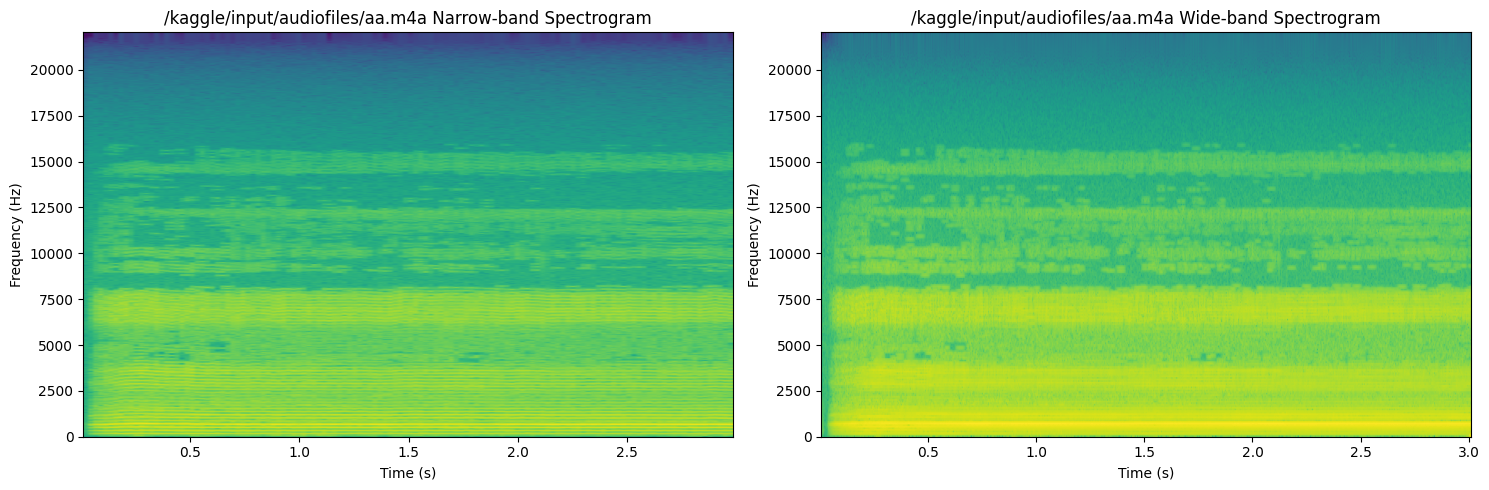

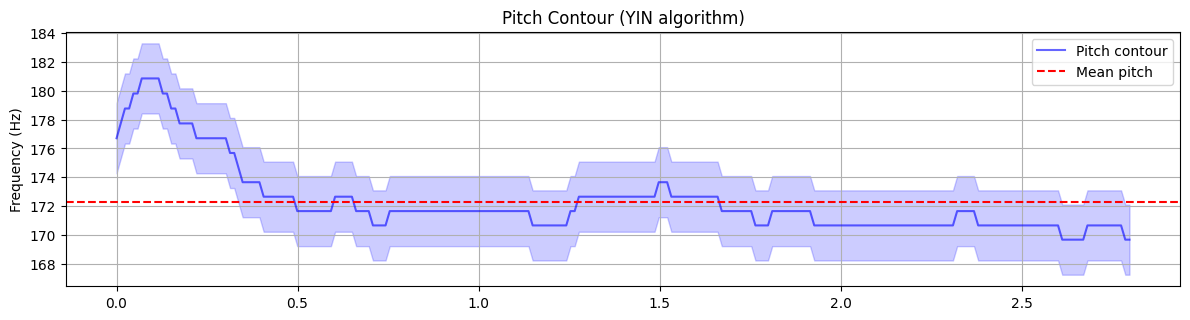


Detailed Pitch Analysis:
Mean pitch: 172.3 Hz
Median pitch: 171.7 Hz
Pitch std dev: 2.4 Hz

Pitch Analysis:
Mean pitch: 172.3 Hz
Median pitch: 171.7 Hz
Pitch std dev: 2.4 Hz


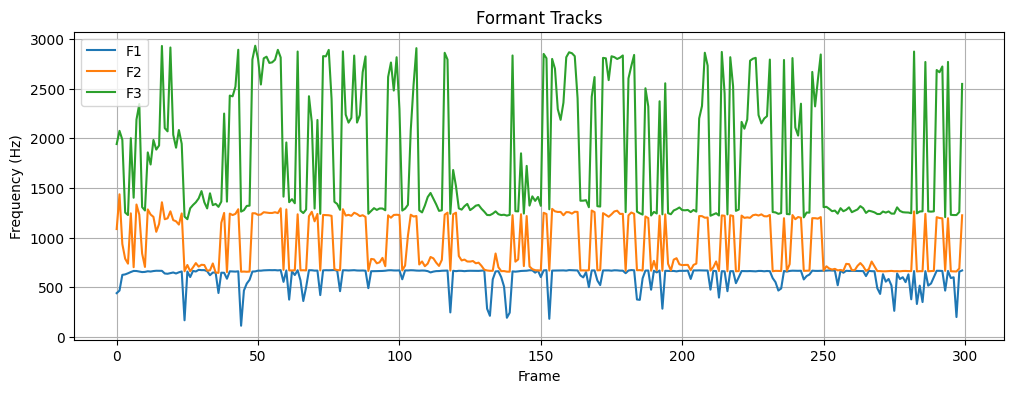


Formant Analysis:
F1: 617.1 Hz
F2: 935.4 Hz
F3: 1818.0 Hz


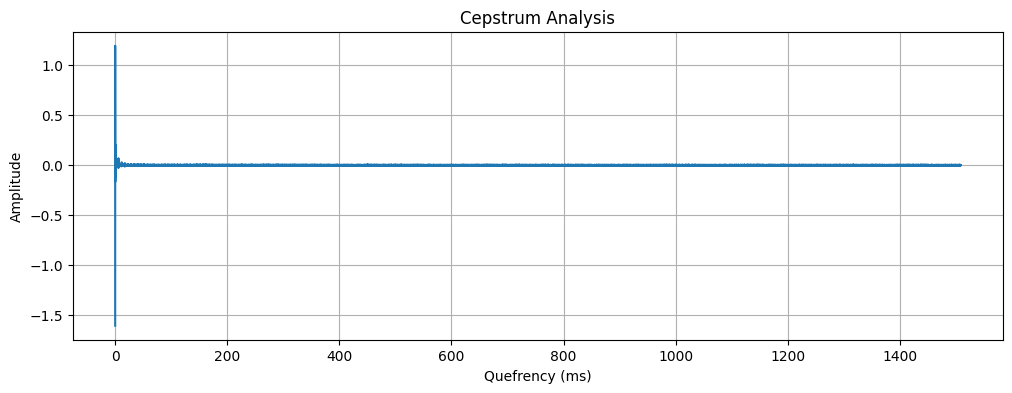


Cepstral Analysis:
Cepstral pitch estimate: 170.9 Hz

Plotting Cepstrum for Initial 10 Frames...


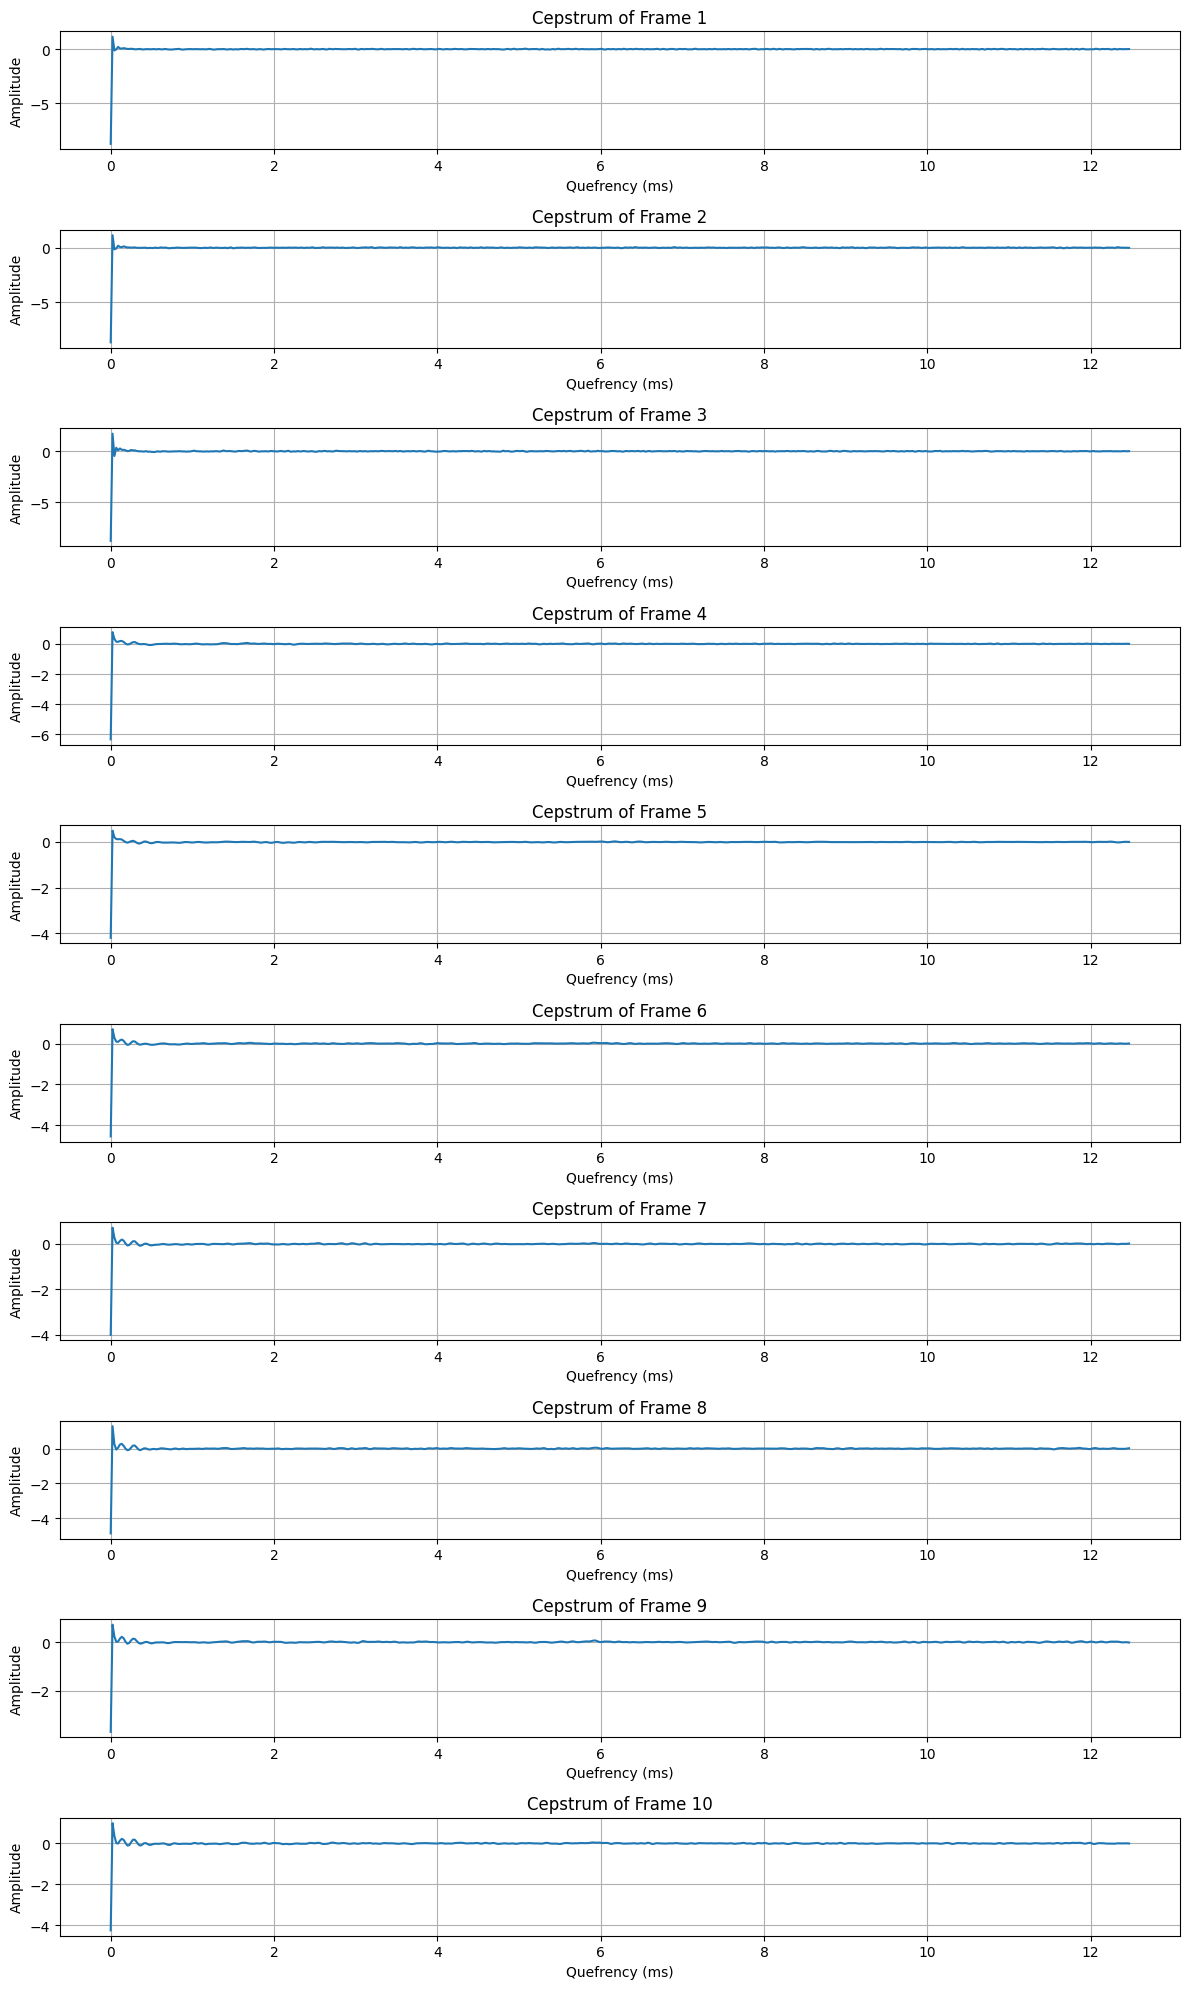


Analyzing /kaggle/input/audiofiles/ii.m4a...
Converting /kaggle/input/audiofiles/ii.m4a to converted_audio.wav...
Loading audio file...
Audio loaded successfully. Sampling rate: 44100 Hz

=== Analysis Results ===


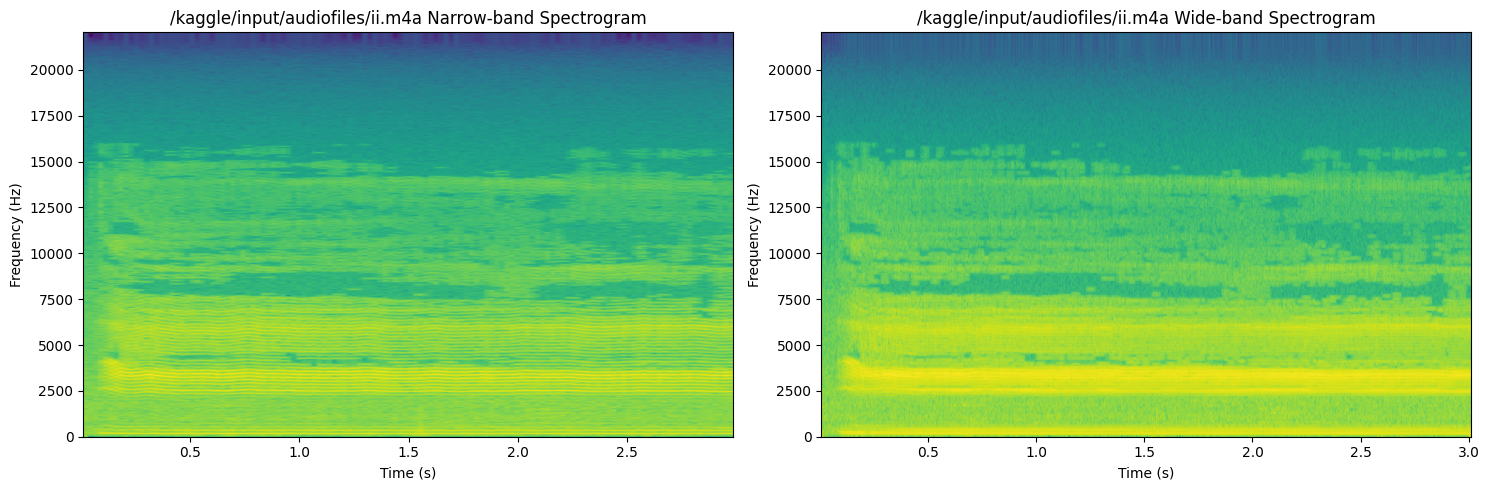

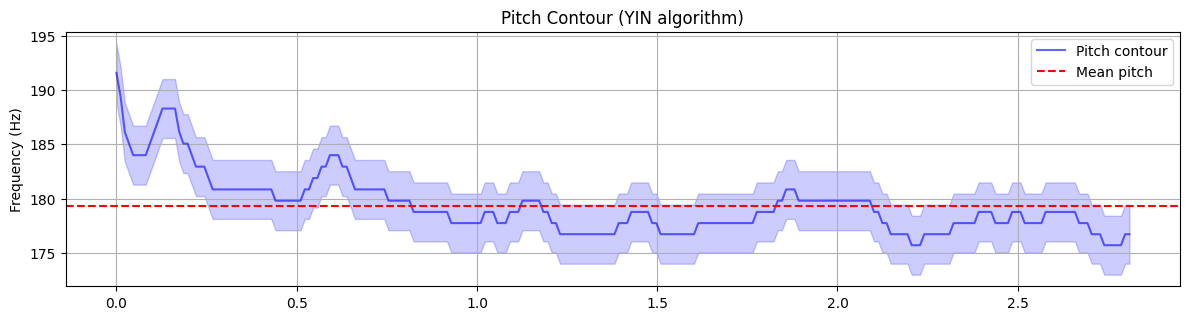


Detailed Pitch Analysis:
Mean pitch: 179.3 Hz
Median pitch: 178.8 Hz
Pitch std dev: 2.7 Hz

Pitch Analysis:
Mean pitch: 179.3 Hz
Median pitch: 178.8 Hz
Pitch std dev: 2.7 Hz


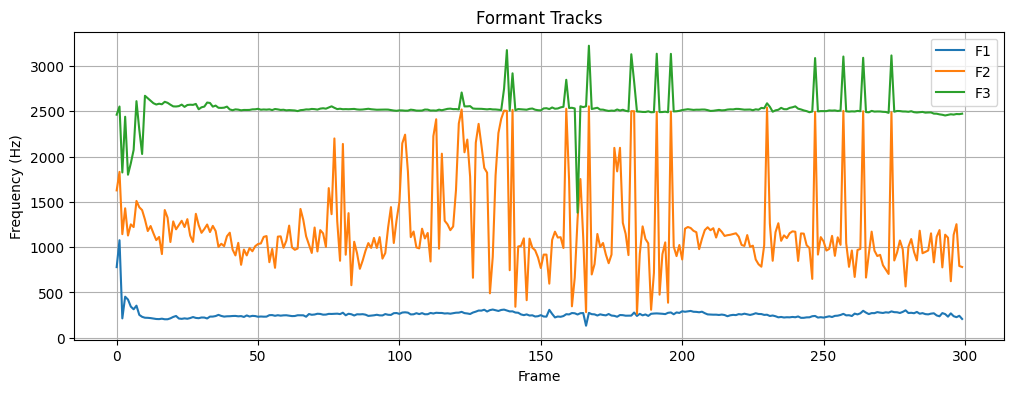


Formant Analysis:
F1: 259.9 Hz
F2: 1197.2 Hz
F3: 2529.1 Hz


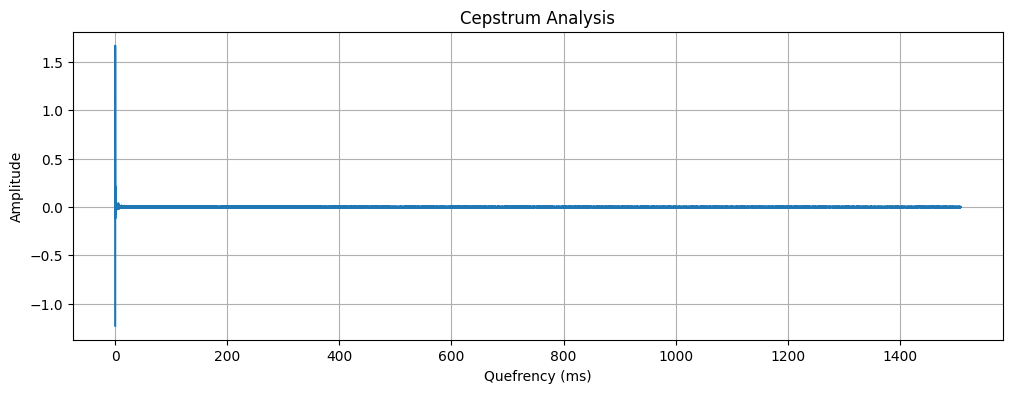


Cepstral Analysis:
Cepstral pitch estimate: 178.5 Hz

Plotting Cepstrum for Initial 10 Frames...


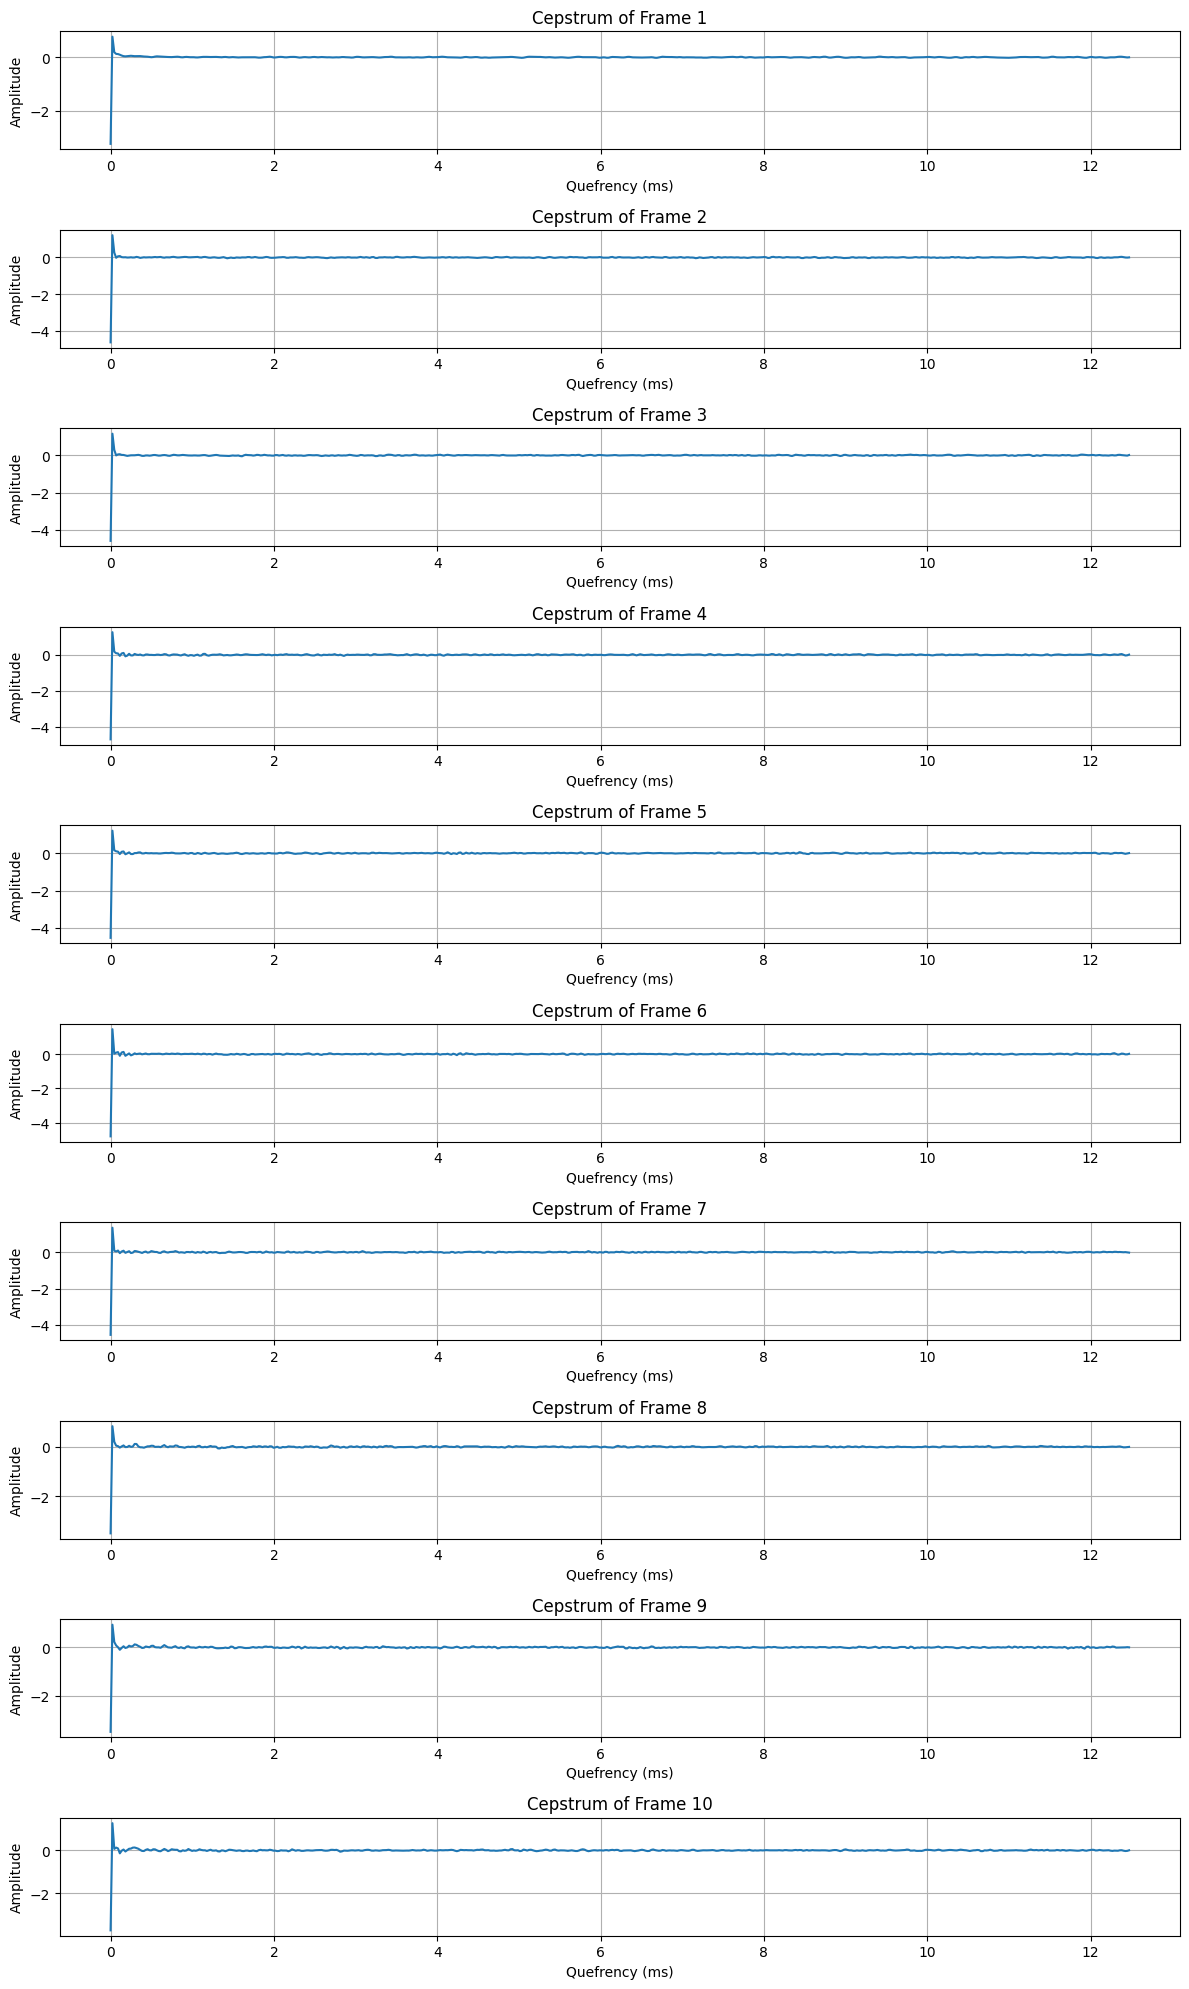


Analyzing /kaggle/input/audiofiles/uu.m4a...
Converting /kaggle/input/audiofiles/uu.m4a to converted_audio.wav...
Loading audio file...
Audio loaded successfully. Sampling rate: 44100 Hz

=== Analysis Results ===


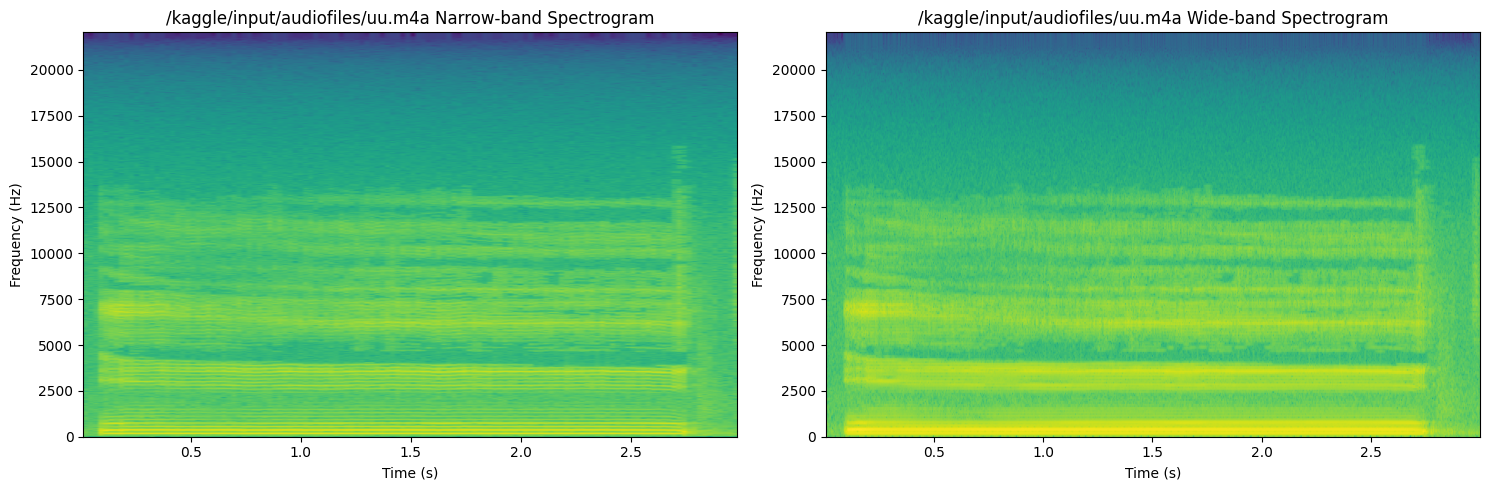

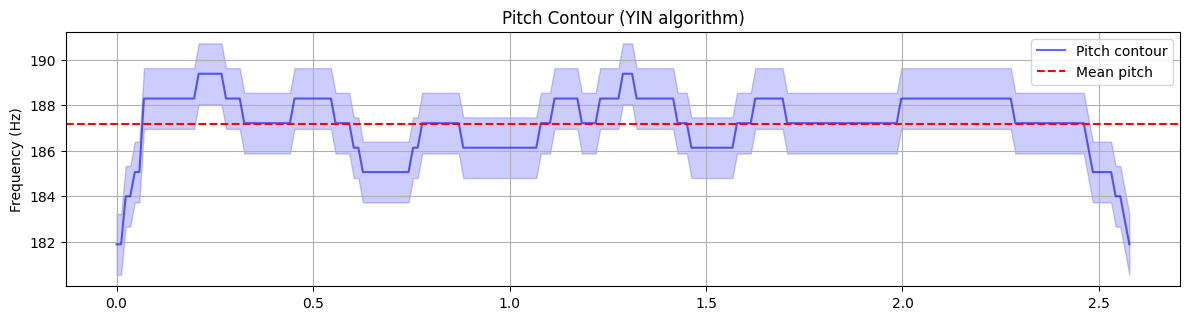


Detailed Pitch Analysis:
Mean pitch: 187.2 Hz
Median pitch: 187.2 Hz
Pitch std dev: 1.3 Hz

Pitch Analysis:
Mean pitch: 187.2 Hz
Median pitch: 187.2 Hz
Pitch std dev: 1.3 Hz


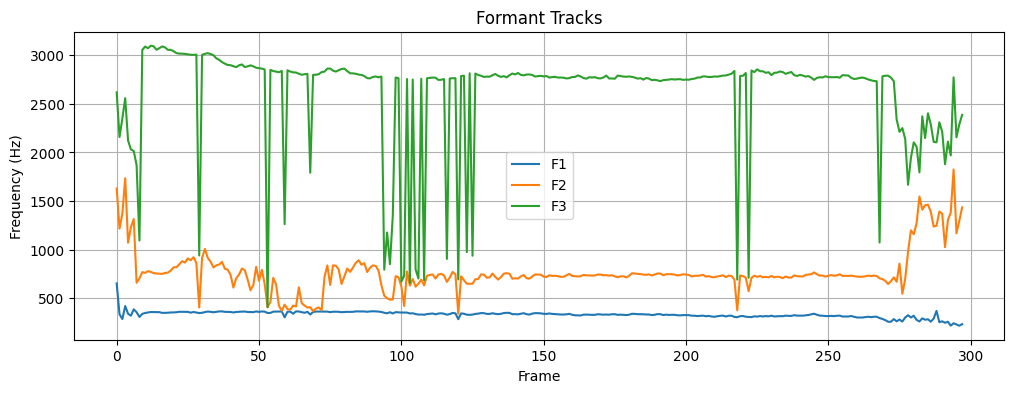


Formant Analysis:
F1: 331.8 Hz
F2: 765.9 Hz
F3: 2609.8 Hz


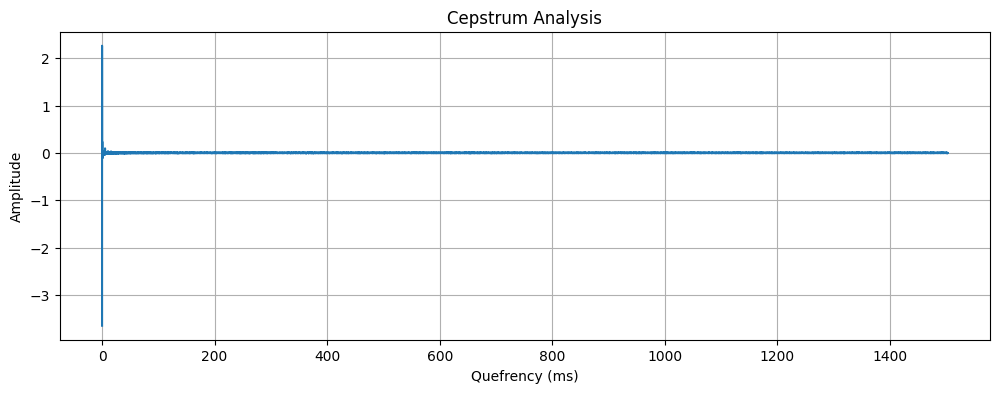


Cepstral Analysis:
Cepstral pitch estimate: 187.7 Hz

Plotting Cepstrum for Initial 10 Frames...


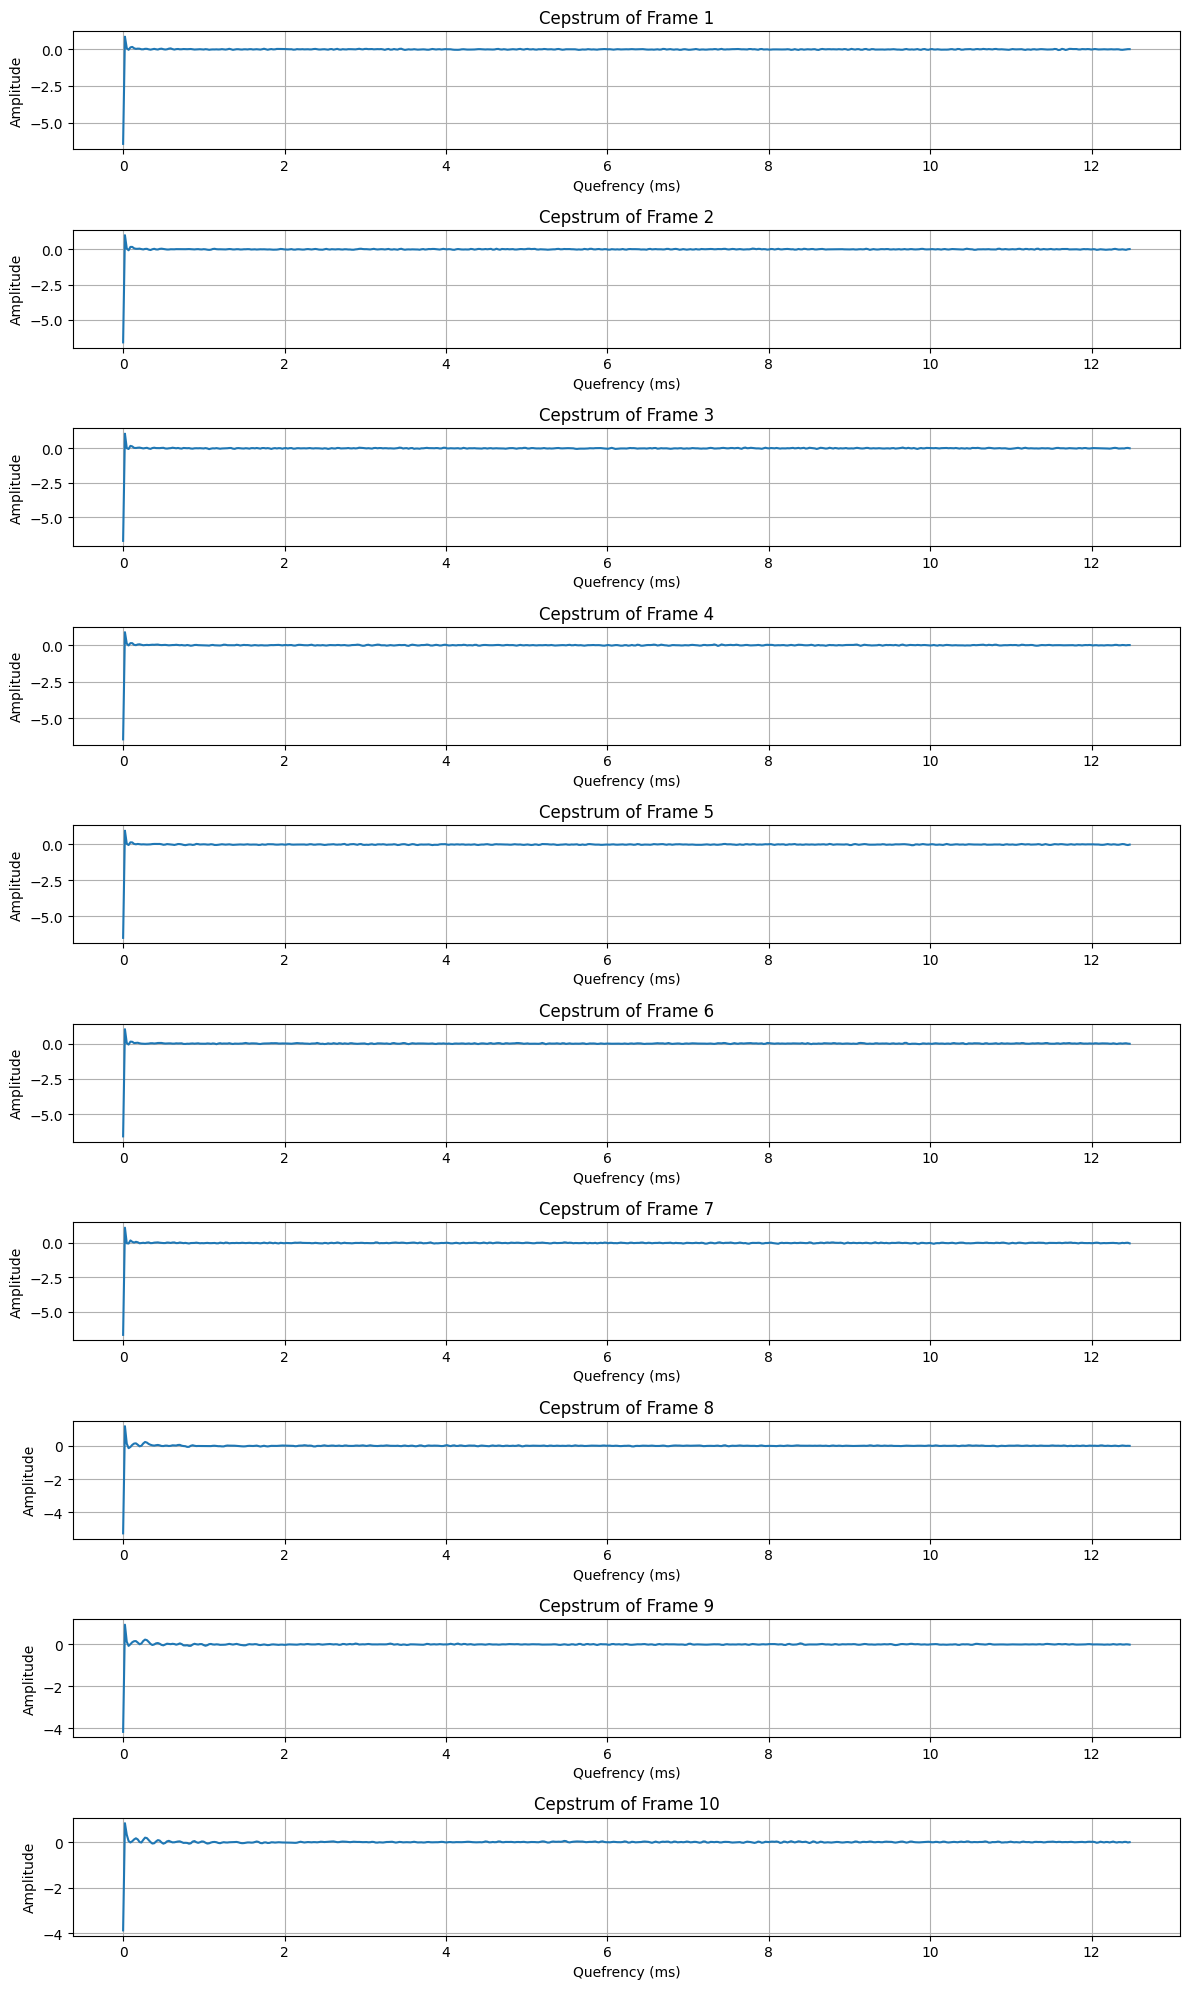

In [28]:
# Run the analysis for each audio file
audio_files = ["/kaggle/input/audiofiles/aa.m4a", 
               "/kaggle/input/audiofiles/ii.m4a", 
               "/kaggle/input/audiofiles/uu.m4a"]

for file in audio_files:
    print(f"\nAnalyzing {file}...")
    analyze_voice(file)